<a href="https://colab.research.google.com/github/caio-git/stance_detection/blob/main/Stance_Detection_definitive_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libs and data

In [1]:
import pandas as pd
import re, nltk, string, scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('rslp')
!pip install unidecode
import unidecode

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
     |████████████████████████████████| 245kB 3.5MB/s 


In [2]:
!wget -O /content/stance_detection_3.zip https://github.com/caio-git/datasets/blob/main/stance_detection_3.zip?raw=true
!unzip /content/stance_detection_3.zip

--2021-07-14 19:31:28--  https://github.com/caio-git/datasets/blob/main/stance_detection_3.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/caio-git/datasets/raw/main/stance_detection_3.zip [following]
--2021-07-14 19:31:28--  https://github.com/caio-git/datasets/raw/main/stance_detection_3.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caio-git/datasets/main/stance_detection_3.zip [following]
--2021-07-14 19:31:28--  https://raw.githubusercontent.com/caio-git/datasets/main/stance_detection_3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

In [3]:
df = pd.read_csv('/content/stance_detection_3.csv', index_col=False)
df.head()

,news,headline,tag
0,a senadora kátia abreu (sem partido-to) disse ...,podemos expulsa gaguim e abre espaco para kati...,disagree
1,"um texto de jorge gauthier, para o blog me sal...",zico critica montagem do elenco no flamengo e ...,disagree
2,"o governador de são paulo, geraldo alckmin, as...",alckmin diz que previa nao divide previa escolhe,disagree
3,o teatro oficina procurou o ministério público...,doria vai receber ze celso apos reuniao com r...,disagree
4,a ministra dos direitos humanos luislinda valo...,laranja de geddel trabalhou na campanha de aecio,disagree


## Text preprocessing

In [4]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords = [unidecode.unidecode(word) for word in stopwords]
stemmer = nltk.stem.RSLPStemmer()

In [5]:
def text_preprocess(text):
  text = re.sub(r'\s+', ' ', text) 
  text = unidecode.unidecode(text)
  text = re.sub('[^a-zA-Z\s]', '', text)
  text = text.lower()

  tokens = []
  for token in nltk.word_tokenize(text):
    tokens.append(token)
      
  tokens = [stemmer.stem(token) for token in tokens if token not in stopwords and token not in string.punctuation]
  preprocessed_text = ' '.join([str(word) for word in tokens if not word.isdigit()])

  return preprocessed_text

In [6]:
df['news_preprocessed'] = df['news'].apply(text_preprocess)
df['headline_preprocessed'] = df['headline'].apply(text_preprocess)
df.drop(columns=['news', 'headline'], inplace=True)

## Cosine similarity feature extraction

In [7]:
vectorizer_for_cos_sim = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=stopwords)

In [8]:
def cos_sim_extractor(news_headline_df):
  news_and_headline = []
  news_and_headline.append(news_headline_df['news_preprocessed'])
  news_and_headline.append(news_headline_df['headline_preprocessed'])
  tfidf = vectorizer_for_cos_sim.fit_transform(news_and_headline)
  cosine_similarity_news_headline = (tfidf * tfidf.T).A
  return cosine_similarity_news_headline[0][1]

In [9]:
df['cosine_similarity_value'] = df.apply(cos_sim_extractor, axis=1)

## Word superposition feature extraction

In [10]:
def superposition_counter(df_x_train):
  news = set(df_x_train['news_preprocessed'].split(' '))
  headline = set(df_x_train['headline_preprocessed'].split(' '))
  superposition = len((news).intersection(headline)) / float(len(news.union(headline)))  
  return superposition

In [11]:
df['superposition'] = df.apply(superposition_counter, axis=1)

## Train test split

In [12]:
X = df.drop(columns=['tag'])
y = df['tag']

In [13]:
y.value_counts()

disagree    2392
agree       2372
Name: tag, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## TF-IDF feature extraction from Training and Test sets

In [15]:
news_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words=stopwords)
train_news_tfidf = news_vectorizer.fit_transform(X_train['news_preprocessed'])
test_news_tfidf = news_vectorizer.transform(X_test['news_preprocessed'])

headline_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words=stopwords)
train_headline_tfidf = headline_vectorizer.fit_transform(X_train['headline_preprocessed'])
test_headline_tfidf = headline_vectorizer.transform(X_test['headline_preprocessed'])

In [16]:
tfidf_news_len = news_vectorizer.get_feature_names()
tfidf_headline_len = headline_vectorizer.get_feature_names()
print('number of news ti-idf tokens: ' + str(len(tfidf_news_len)) + '\nnumber of headline ti-idf tokens: ' + str(len(tfidf_headline_len)))

number of news ti-idf tokens: 676164
number of headline ti-idf tokens: 22411


In [17]:
feature_names = np.array(tfidf_news_len)
sorted_by_idf = np.argsort(news_vectorizer.idf_)
print("Features with highest idf:\n{}\n".format(feature_names[sorted_by_idf[-10:]]))
print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:10]]))

Features with highest idf:
['fat supost' 'fat sob' 'fat soc' 'fat sol' 'fat somams' 'fat sonh'
 'fat suced' 'fat sucess' 'fat sobr' 'inter clar']

Features with lowest idf:
['diss' 'pod' 'ser' 'ano' 'cas' 'outr' 'brasil' 'sobr' 'tod' 'part']


## Adjusting data for ML input

In [18]:
training_superposition = scipy.sparse.coo_matrix(X_train.superposition.values)
test_superposition = scipy.sparse.coo_matrix(X_test.superposition.values)
training_cos_sim = scipy.sparse.coo_matrix(X_train.cosine_similarity_value.values)
test_cos_sim = scipy.sparse.coo_matrix(X_test.cosine_similarity_value.values)

training_tfidf = scipy.sparse.hstack([train_news_tfidf, train_headline_tfidf])
test_tfidf = scipy.sparse.hstack([test_news_tfidf, test_headline_tfidf])

training_features = scipy.sparse.bmat([[training_tfidf, training_cos_sim.T, training_superposition.T]])
test_features = scipy.sparse.bmat([[test_tfidf, test_cos_sim.T, test_superposition.T]])

In [19]:
df_X_train = X_train.drop(columns=['news_preprocessed', 'headline_preprocessed'])

In [20]:
training_features_normalized = preprocessing.normalize(training_features)

In [21]:
test_features_normalized = preprocessing.normalize(test_features)

In [22]:
df_X_test = X_test.drop(columns=['news_preprocessed', 'headline_preprocessed'])

### Logistic Regression (cosine similarity and word superposition)

In [23]:
logistic_regression_clf = LogisticRegression()
logistic_regression_clf.fit(df_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
lr_accuracy = logistic_regression_clf.score(df_X_test, y_test)
lr_accuracy

0.7853146853146853

In [25]:
y_pred_lr = logistic_regression_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

       agree       0.83      0.71      0.76       696
    disagree       0.76      0.86      0.80       734

    accuracy                           0.79      1430
   macro avg       0.79      0.78      0.78      1430
weighted avg       0.79      0.79      0.78      1430



In [26]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[492, 204],
       [103, 631]])

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
(tn, fp, fn, tp)

(492, 204, 103, 631)

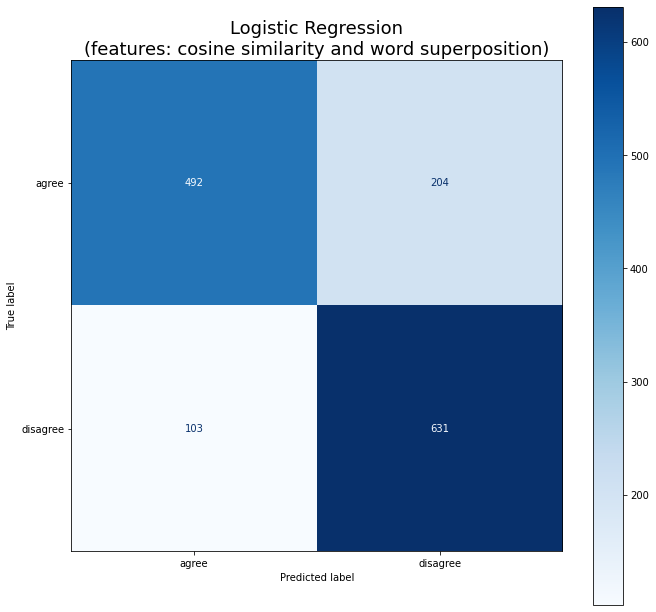

In [28]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(features: cosine similarity and word superposition)', fontsize='18')
plot_confusion_matrix(logistic_regression_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Logistic Regression hyperparameter tunning

In [29]:
c_space = np.logspace(-3, 3, 30)
grid_values = {'C': c_space}
gs_logistic_regression_clf = GridSearchCV(logistic_regression_clf, param_grid=grid_values, cv=5)

In [30]:
gs_logistic_regression_clf.fit(df_X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.6...
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6

In [31]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(gs_logistic_regression_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(gs_logistic_regression_clf.best_score_))

Tuned Logistic Regression Parameter: {'C': 22.122162910704503}
Tuned Logistic Regression Accuracy: 0.8023452237845042


## Logistic Regression (all features)

In [32]:
logistic_regression_all = LogisticRegression()
logistic_regression_all.fit(training_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
lr_accuracy_all = logistic_regression_all.score(test_features, y_test)
lr_accuracy_all

0.8447552447552448

In [34]:
y_pred_lr_all = logistic_regression_all.predict(test_features)
print(classification_report(y_test, y_pred_lr_all))

              precision    recall  f1-score   support

       agree       0.89      0.78      0.83       696
    disagree       0.81      0.90      0.86       734

    accuracy                           0.84      1430
   macro avg       0.85      0.84      0.84      1430
weighted avg       0.85      0.84      0.84      1430



In [35]:
cm_lr_all = confusion_matrix(y_test, y_pred_lr_all)
cm_lr_all

array([[544, 152],
       [ 70, 664]])

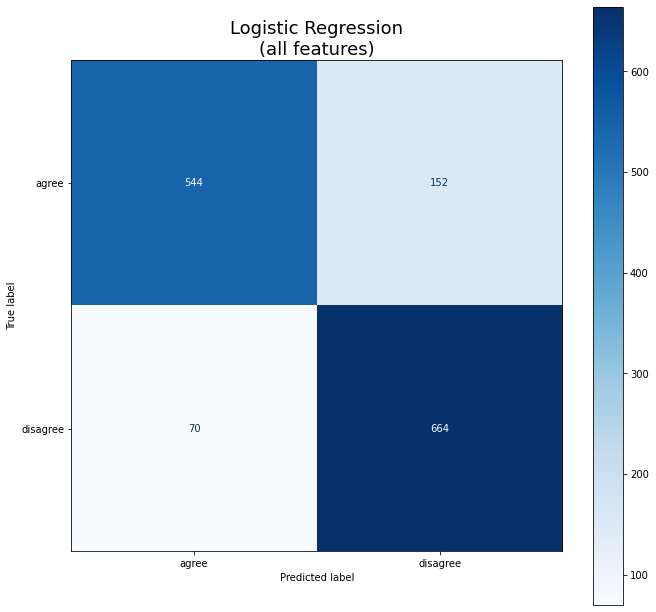

In [36]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(all features)', fontsize='18')
plot_confusion_matrix(logistic_regression_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Logistic regression (all features) normalized

In [37]:
logistic_regression_all = LogisticRegression()
logistic_regression_all.fit(training_features_normalized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
logistic_regression_all.score(test_features_normalized, y_test)

0.8349650349650349

In [39]:
y_pred_lr_all = logistic_regression_all.predict(test_features_normalized)
print(classification_report(y_test, y_pred_lr_all))

              precision    recall  f1-score   support

       agree       0.88      0.76      0.82       696
    disagree       0.80      0.91      0.85       734

    accuracy                           0.83      1430
   macro avg       0.84      0.83      0.83      1430
weighted avg       0.84      0.83      0.83      1430



In [40]:
cm_lr_all = confusion_matrix(y_test, y_pred_lr_all)
cm_lr_all

array([[529, 167],
       [ 69, 665]])

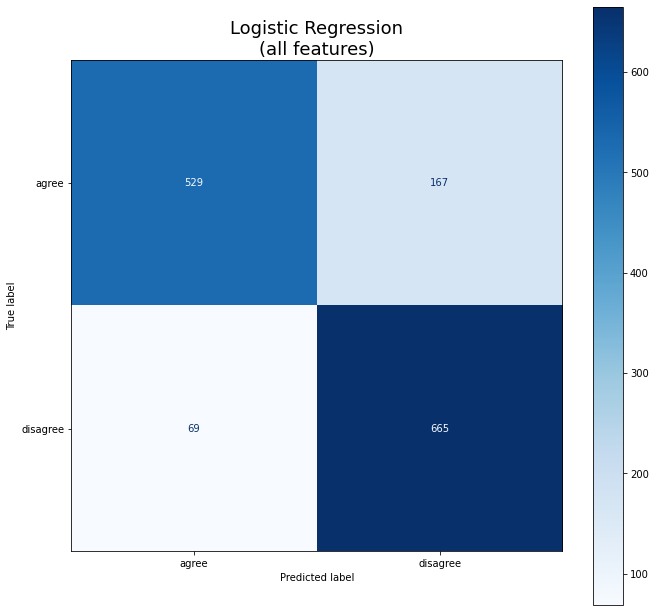

In [41]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(all features)', fontsize='18')
plot_confusion_matrix(logistic_regression_all, test_features_normalized, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Naive Bayes (cosine similarity and word superposition)

In [42]:
#naive_bayes_clf = ComplementNB(alpha=0.01, class_prior=None, fit_prior=True)
naive_bayes_clf = MultinomialNB(fit_prior=False)
naive_bayes_clf.fit(df_X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [43]:
nb_accuracy = naive_bayes_clf.score(df_X_test, y_test)
nb_accuracy

0.5272727272727272

In [44]:
y_pred_nb = naive_bayes_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_nb, zero_division=0))

              precision    recall  f1-score   support

       agree       0.51      0.60      0.55       696
    disagree       0.55      0.45      0.50       734

    accuracy                           0.53      1430
   macro avg       0.53      0.53      0.53      1430
weighted avg       0.53      0.53      0.52      1430



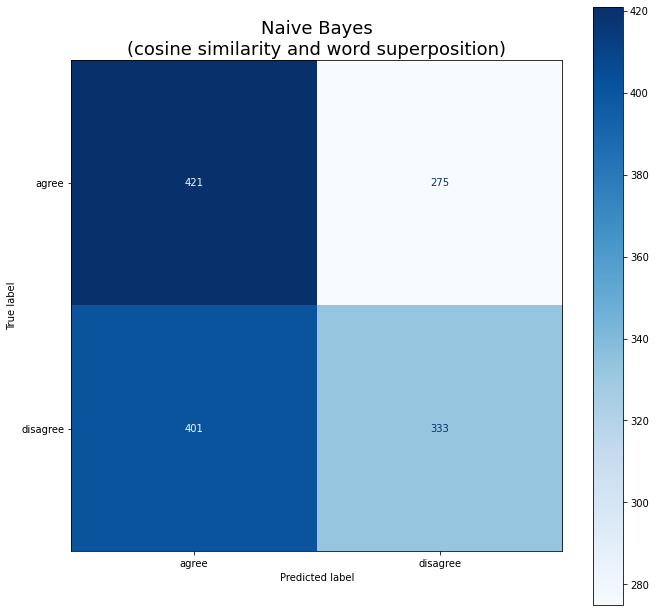

In [45]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(cosine similarity and word superposition)', fontsize='18')
plot_confusion_matrix(naive_bayes_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Naive Bayes (all features)

In [46]:
#naive_bayes_all = ComplementNB()
#naive_bayes_all = GaussianNB()
naive_bayes_all = MultinomialNB()
naive_bayes_all.fit(training_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
nb_accuracy_all = naive_bayes_all.score(test_features, y_test)
nb_accuracy_all

0.6776223776223776

In [48]:
y_pred_nb_all = naive_bayes_all.predict(test_features)
print(classification_report(y_test, y_pred_nb_all))

              precision    recall  f1-score   support

       agree       0.64      0.78      0.70       696
    disagree       0.74      0.58      0.65       734

    accuracy                           0.68      1430
   macro avg       0.69      0.68      0.68      1430
weighted avg       0.69      0.68      0.67      1430



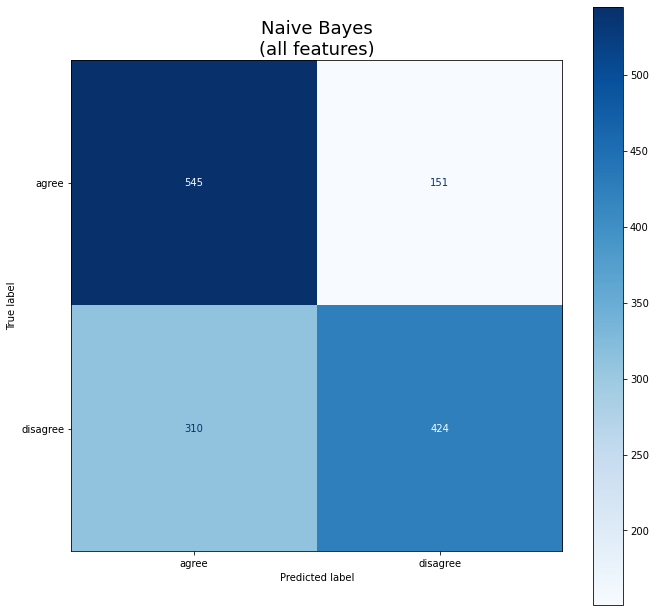

In [49]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(all features)', fontsize='18')
plot_confusion_matrix(naive_bayes_all,test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Naive Bayes (all features) hyperparameter tunning

In [50]:
alpha_space = np.logspace(-9, 9, 50)
grid_values = {'alpha': alpha_space}
gs_naive_bayes_all = GridSearchCV(naive_bayes_all, param_grid=grid_values, cv=5)

In [51]:
gs_naive_bayes_all.fit(training_features_normalized, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-09, 2.32995181e-09, 5.42867544e-09, 1.26485522e-08,
       2.94705170e-08, 6.86648845e-08, 1.59985872e-07, 3.72759372e-07,
       8.68511374e-07, 2.02358965e-06, 4.71486636e-06, 1.09854114e-05,
       2.55954792e-0...
       5.68986603e+02, 1.32571137e+03, 3.08884360e+03, 7.19685673e+03,
       1.67683294e+04, 3.90693994e+04, 9.10298178e+04, 2.12095089e+05,
       4.94171336e+05, 1.15139540e+06, 2.68269580e+06, 6.25055193e+06,
       1.45634848e+07, 3.39322177e+07, 7.90604321e+07, 1.84206997e+08,
       4.29193426e+08, 1.00000000e+09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [52]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(gs_naive_bayes_all.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(gs_naive_bayes_all.best_score_))

Tuned Logistic Regression Parameter: {'alpha': 1.5264179671752365}
Tuned Logistic Regression Accuracy: 0.7000594297445872


### Naive bayes (all features) normalized

In [53]:
#naive_bayes_all = ComplementNB()
naive_bayes_all_normalized = MultinomialNB()
naive_bayes_all_normalized.fit(training_features_normalized, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
naive_bayes_all_normalized.score(test_features_normalized, y_test)

0.6818181818181818

In [55]:
y_pred_nb_all = naive_bayes_all_normalized.predict(test_features_normalized)
print(classification_report(y_test, y_pred_nb_all))

              precision    recall  f1-score   support

       agree       0.64      0.79      0.71       696
    disagree       0.74      0.58      0.65       734

    accuracy                           0.68      1430
   macro avg       0.69      0.68      0.68      1430
weighted avg       0.69      0.68      0.68      1430



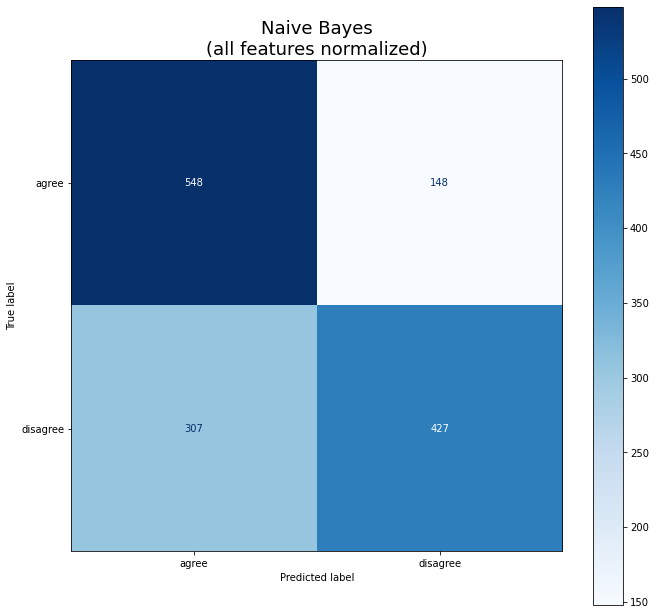

In [56]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(all features normalized)', fontsize='18')
plot_confusion_matrix(naive_bayes_all_normalized,test_features_normalized, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Random Forest (cosine similarity and word superposition)

In [57]:
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(df_X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
rf_accuracy = random_forest_clf.score(df_X_test, y_test)
rf_accuracy

0.7748251748251749

In [59]:
y_pred_rf = random_forest_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       agree       0.79      0.74      0.76       696
    disagree       0.76      0.81      0.79       734

    accuracy                           0.77      1430
   macro avg       0.78      0.77      0.77      1430
weighted avg       0.78      0.77      0.77      1430



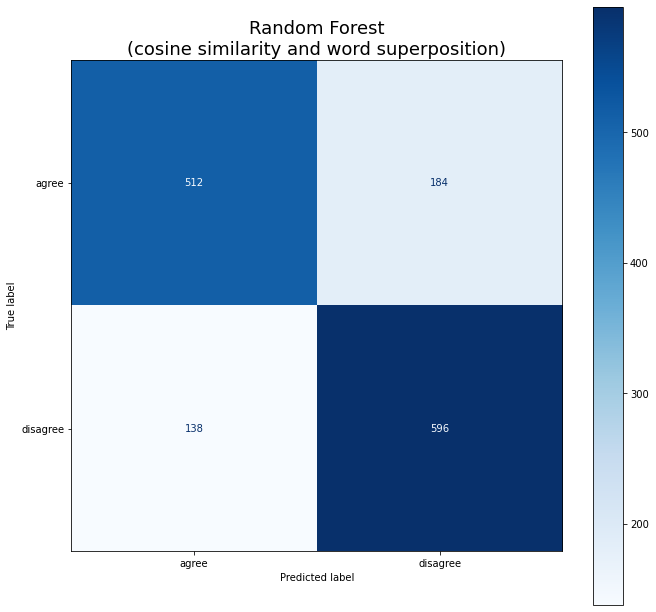

In [60]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(cosine similarity and word superposition)', fontsize='18')
plot_confusion_matrix(random_forest_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Random Forest (all features)

In [61]:
random_forest_all = RandomForestClassifier()
random_forest_all.fit(training_features, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
rf_accuracy_all = random_forest_all.score(test_features, y_test)

In [63]:
y_pred_rf_all = random_forest_all.predict(test_features)
print(classification_report(y_test, y_pred_rf_all))

              precision    recall  f1-score   support

       agree       0.69      0.72      0.70       696
    disagree       0.72      0.69      0.71       734

    accuracy                           0.70      1430
   macro avg       0.70      0.70      0.70      1430
weighted avg       0.70      0.70      0.70      1430



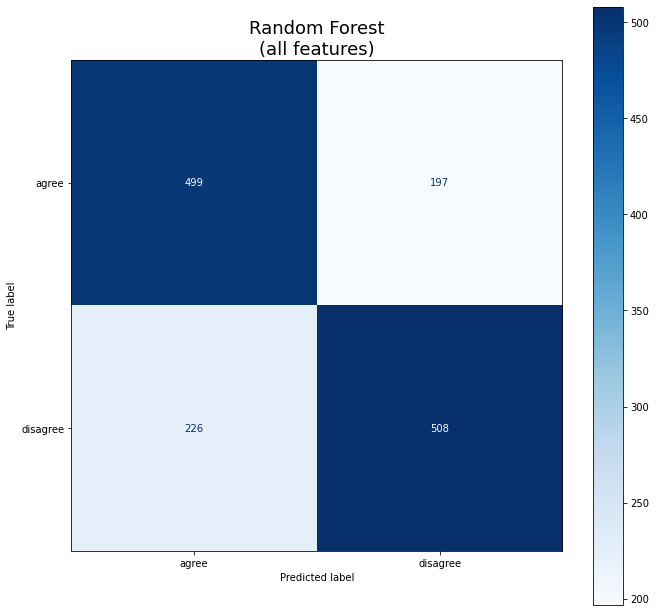

In [64]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(all features)', fontsize='18')
plot_confusion_matrix(random_forest_all,test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Multi-layer Perceptron Classifier (cosine similarity and word superposition)

In [65]:
neural_network_clf = MLPClassifier()
neural_network_clf.fit(df_X_test, y_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [66]:
nn_accuracy = neural_network_clf.score(df_X_test, y_test)
nn_accuracy

0.7923076923076923

In [67]:
y_pred_mlpc = neural_network_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_mlpc))

              precision    recall  f1-score   support

       agree       0.84      0.71      0.77       696
    disagree       0.76      0.87      0.81       734

    accuracy                           0.79      1430
   macro avg       0.80      0.79      0.79      1430
weighted avg       0.80      0.79      0.79      1430



In [68]:
cm_mplc = confusion_matrix(y_test, y_pred_mlpc)
cm_mplc

array([[495, 201],
       [ 96, 638]])

In [69]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlpc).ravel()
(tn, fp, fn, tp)

(495, 201, 96, 638)

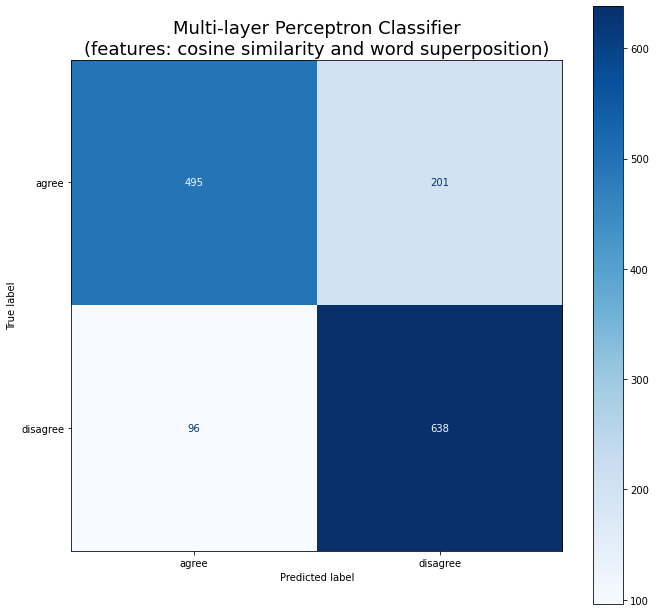

In [70]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(features: cosine similarity and word superposition)', fontsize='18')
plot_confusion_matrix(neural_network_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

### Multi-layer Perceptron Classifier (all features)

In [71]:
neural_network_all = MLPClassifier()
neural_network_all.fit(training_features, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [72]:
nn_accuracy_all = neural_network_all.score(test_features, y_test)
nn_accuracy_all

0.7125874125874125

In [73]:
y_pred_lr_all = logistic_regression_all.predict(test_features)
print(classification_report(y_test, y_pred_lr_all))

              precision    recall  f1-score   support

       agree       0.81      0.86      0.83       696
    disagree       0.86      0.81      0.84       734

    accuracy                           0.83      1430
   macro avg       0.84      0.84      0.83      1430
weighted avg       0.84      0.83      0.83      1430



In [74]:
cm_lr_all = confusion_matrix(y_test, y_pred_lr_all)
cm_lr_all

array([[596, 100],
       [136, 598]])

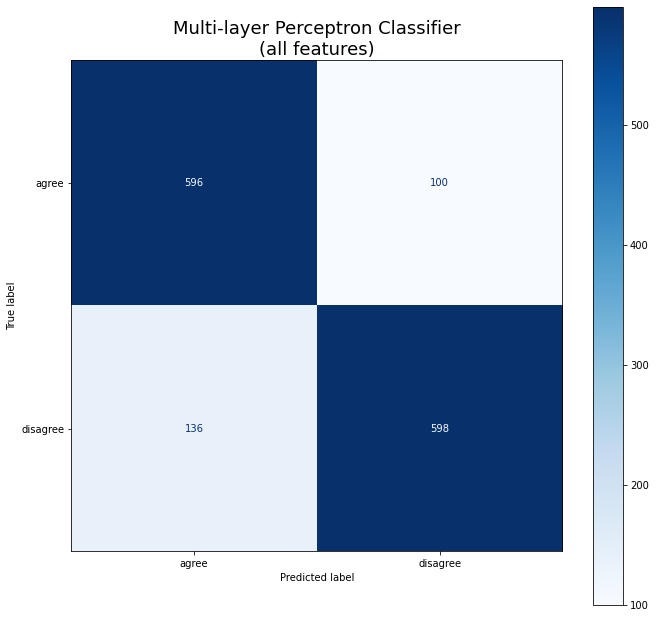

In [75]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(all features)', fontsize='18')
plot_confusion_matrix(logistic_regression_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

## ROC curves

### ROC curves (consine similarity and word superposition)

In [76]:
def change(f):
    if f == 'disagree':
        return 1    
    else:
        return 0

y_train_number = [change(x) for x in y_train]
y_test_number = [change(x) for x in y_test]

In [77]:
r_probs = [0 for _ in range(len(y_test_number))]
lr_probs = logistic_regression_clf.predict_proba(df_X_test)[:, 1]
nb_probs = naive_bayes_clf.predict_proba(df_X_test)[:, 1]
rf_probs = random_forest_clf.predict_proba(df_X_test)[:, 1]
nn_probs = neural_network_clf.predict_proba(df_X_test)[:, 1]

In [78]:
r_auc = roc_auc_score(y_test_number, r_probs)
lr_auc = roc_auc_score(y_test_number, lr_probs)
nb_auc = roc_auc_score(y_test_number, nb_probs)
rf_auc = roc_auc_score(y_test_number, rf_probs)
nn_auc = roc_auc_score(y_test_number, nn_probs)

In [79]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Neural Network: AUROC = %.3f' % (nn_auc))

Random (chance) Prediction: AUROC = 0.500
Logistic Regression: AUROC = 0.842
Naive Bayes: AUROC = 0.584
Random Forest: AUROC = 0.843
Neural Network: AUROC = 0.842


In [80]:
r_fpr, r_tpr, _ = roc_curve(y_test_number, r_probs)#, pos_label='disagree')
lr_fpr, lr_tpr, _ = roc_curve(y_test_number, lr_probs)#, pos_label='disagree')
nb_fpr, nb_tpr, _ = roc_curve(y_test_number, nb_probs)#, pos_label='disagree')
rf_fpr, rf_tpr, _ = roc_curve(y_test_number, rf_probs)#, pos_label='disagree')
nn_fpr, nn_tpr, _ = roc_curve(y_test_number, nn_probs)#, pos_label='disagree')

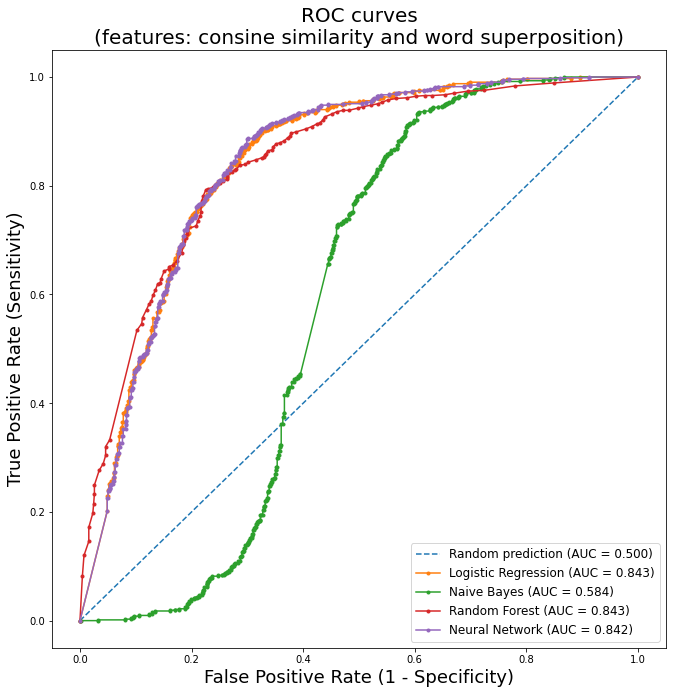

In [81]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc)
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc)

# Title
plt.title('ROC curves\n(features: consine similarity and word superposition)', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
plt.legend(fontsize='12') # 
# Show plot
plt.show()

### ROC curves (all features)

In [82]:
r_probs_all = [0 for _ in range(len(y_test_number))]
lr_probs_all = logistic_regression_all.predict_proba(test_features)[:, 1]
nb_probs_all = naive_bayes_all.predict_proba(test_features)[:, 1]
rf_probs_all = random_forest_all.predict_proba(test_features)[:, 1]
nn_probs_all = neural_network_all.predict_proba(test_features)[:, 1]

In [83]:
r_auc_all = roc_auc_score(y_test_number, r_probs_all)
lr_auc_all = roc_auc_score(y_test_number, lr_probs_all)
nb_auc_all = roc_auc_score(y_test_number, nb_probs_all)
rf_auc_all = roc_auc_score(y_test_number, rf_probs_all)
nn_auc_all = roc_auc_score(y_test_number, nn_probs_all)

In [84]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc_all))
print('Linear Regression: AUROC = %.3f' % (lr_auc_all))
print('Naive Bayes: AUROC = %.3f' % (nb_auc_all))
print('Random Forest: AUROC = %.3f' % (rf_auc_all))
print('Neural Network: AUROC = %.3f' % (nn_auc_all))

Random (chance) Prediction: AUROC = 0.500
Linear Regression: AUROC = 0.916
Naive Bayes: AUROC = 0.756
Random Forest: AUROC = 0.790
Neural Network: AUROC = 0.786


In [85]:
r_fpr_all, r_tpr_all, _ = roc_curve(y_test_number, r_probs_all)#, pos_label='disagree')
lr_fpr_all, lr_tpr_all, _ = roc_curve(y_test_number, lr_probs_all)#, pos_label='disagree')
nb_fpr_all, nb_tpr_all, _ = roc_curve(y_test_number, nb_probs_all)#, pos_label='disagree')
rf_fpr_all, rf_tpr_all, _ = roc_curve(y_test_number, rf_probs_all)#, pos_label='disagree')
nn_fpr_all, nn_tpr_all, _ = roc_curve(y_test_number, nn_probs_all)#, pos_label='disagree')

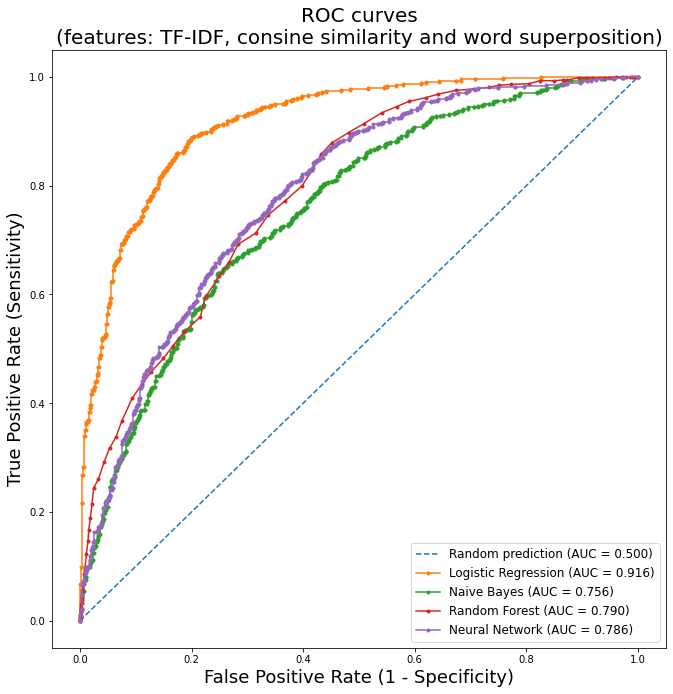

In [86]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr_all, r_tpr_all, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc_all)
plt.plot(lr_fpr_all, lr_tpr_all, marker='.', label='Logistic Regression (AUC = %0.3f)' % lr_auc_all)
plt.plot(nb_fpr_all, nb_tpr_all, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc_all)
plt.plot(rf_fpr_all, rf_tpr_all, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc_all)
plt.plot(nn_fpr_all, nn_tpr_all, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc_all)

# Title
plt.title('ROC curves\n(features: TF-IDF, consine similarity and word superposition)', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
plt.legend(fontsize='12') # 
# Show plot
plt.show()

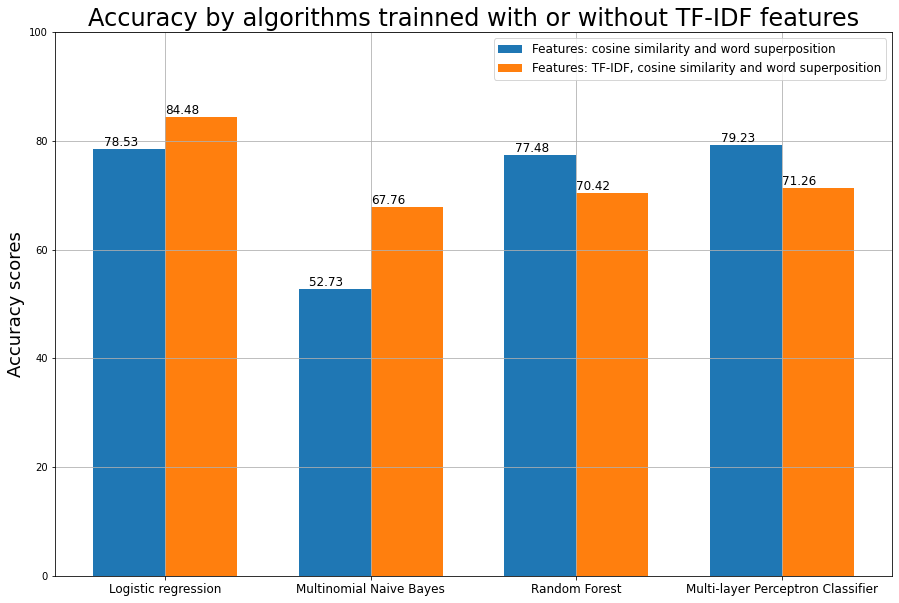

[78.53, 52.73, 77.48, 79.23]


In [87]:
labels = ['Logistic regression', 'Multinomial Naive Bayes', 'Random Forest', 'Multi-layer Perceptron Classifier']
scores = [lr_accuracy, nb_accuracy, rf_accuracy, nn_accuracy]
scores = [round(i * 100, 2) for i in scores]

scores_all = [lr_accuracy_all, nb_accuracy_all, rf_accuracy_all, nn_accuracy_all]
scores_all = [round(i * 100, 2) for i in scores_all]

w = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(w - width/2, scores, width, label='Features: cosine similarity and word superposition')
rects2 = ax.bar(w + width/2, scores_all, width, label='Features: TF-IDF, cosine similarity and word superposition')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores', fontsize='18')
ax.set_title('Accuracy by algorithms trainned with or without TF-IDF features', fontsize='24')
ax.set_xticks(w)

ax.set_xticklabels(labels, fontsize='12')
ax.legend(fontsize='12')
#ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()

for i in range(len(scores)):
    ax.annotate(str(scores[i])+'       ', xy=(w[i],scores[i]), ha='right', va='bottom', fontsize='12')

for i in range(len(scores_all)):
    ax.annotate(str(scores_all[i]), xy=(w[i],scores_all[i]), ha='left', va='bottom', fontsize='12')    


plt.ylim([0, 100])
#fig.tight_layout()

plt.show()
print(scores)

## Confusion matrices comparative

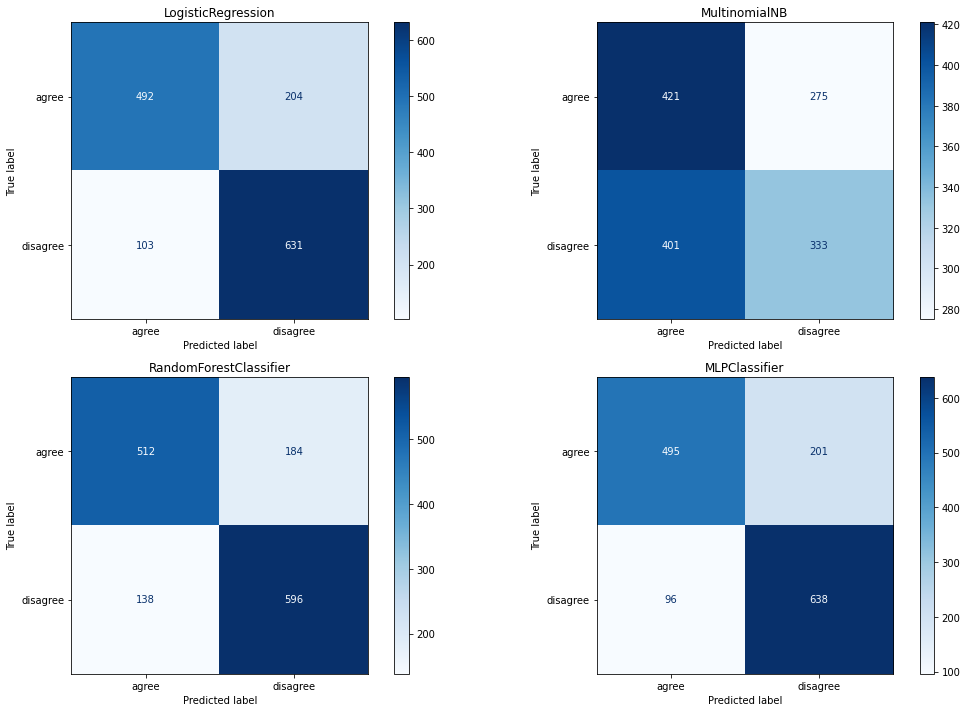

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers = [logistic_regression_clf, naive_bayes_clf, random_forest_clf, neural_network_clf]

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          df_X_test, 
                          y_test, 
                          ax=ax,
                          values_format='d', 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

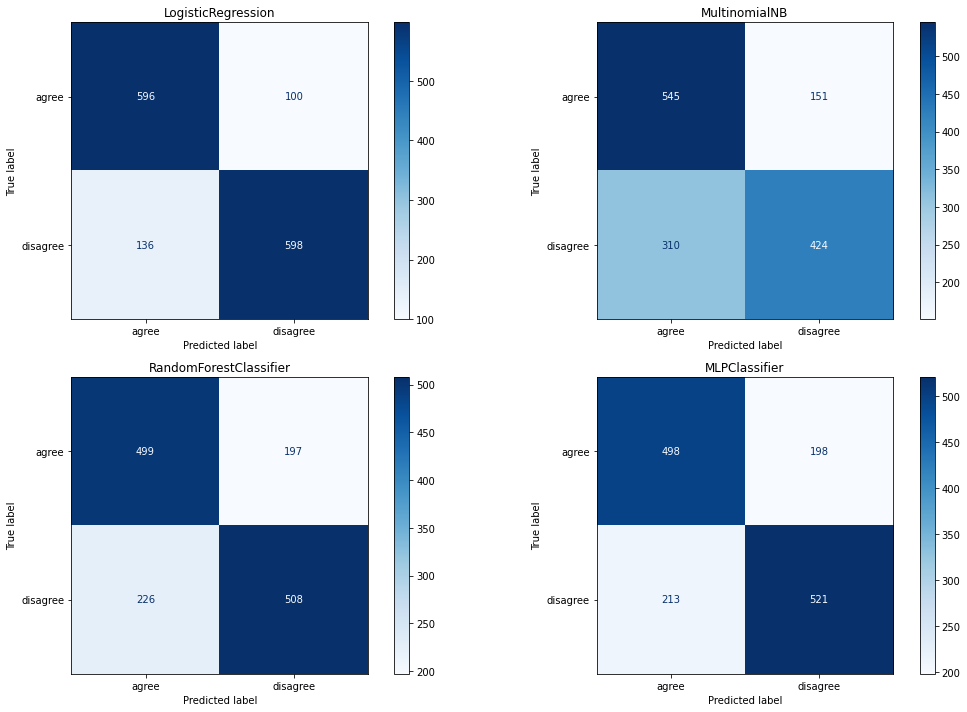

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers_all = [logistic_regression_all, naive_bayes_all, random_forest_all, neural_network_all]

for cls, ax in zip(classifiers_all, axes.flatten()):
    plot_confusion_matrix(cls, 
                          test_features, 
                          y_test, 
                          ax=ax,
                          values_format='d', 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

To be continued...

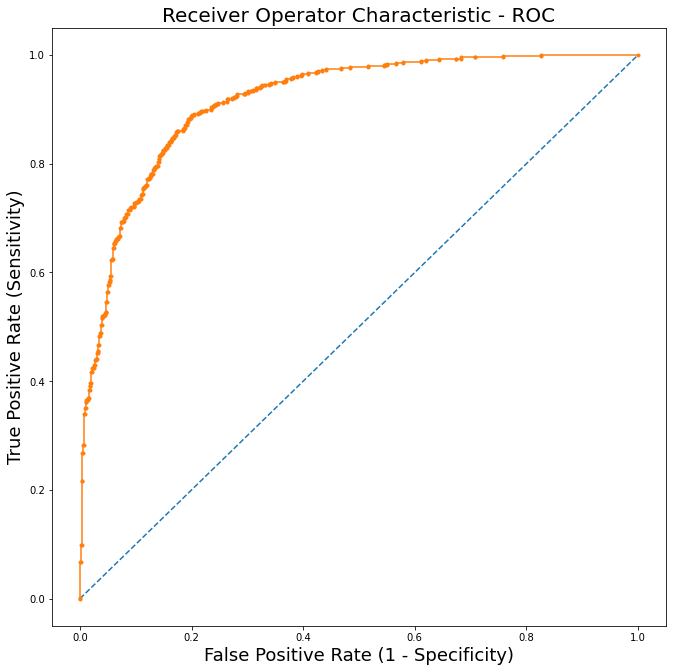

In [90]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr_all, r_tpr_all, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc_all)
plt.plot(lr_fpr_all, lr_tpr_all, marker='.', label='Logistic Regression (AUC = %0.3f)' % lr_auc_all)
#plt.plot(nb_fpr_all, nb_tpr_all, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc_all)
#plt.plot(rf_fpr_all, rf_tpr_all, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc_all)
#plt.plot(nn_fpr_all, nn_tpr_all, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc_all)

# Title
plt.title('Receiver Operator Characteristic - ROC', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
#plt.legend(fontsize='12') # 
# Show plot
plt.show()